

https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://towardsdatascience.com/how-to-make-the-most-out-of-bert-finetuning-d7c9f2ca806c

https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

https://huggingface.co/transformers/glossary.html

Warmup and annealing


In [ ]:
!pip install transformers

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW, AutoConfig, AutoModel, get_linear_schedule_with_warmup
from transformers import DistilBertTokenizerFast, AutoModelForSequenceClassification, BertModel
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
train_data = pd.read_csv ('https://raw.githubusercontent.com/ltgoslo/NorBERT/main/benchmarking/data/sentiment/no/train.csv', header = None)
dev_data = pd.read_csv ('https://raw.githubusercontent.com/ltgoslo/NorBERT/main/benchmarking/data/sentiment/no/dev.csv', header = None)
test_data = pd.read_csv ('https://raw.githubusercontent.com/ltgoslo/NorBERT/main/benchmarking/data/sentiment/no/test.csv', header = None)

In [ ]:
train_data

,0,1
0,0,Verre er det med slagsmålene .
1,0,"Klipperen har overtatt Seagals martial art , o..."
2,1,Ei finslig dame skal bli med på kjøret og obse...
3,0,"Hvis du vil fremstå som seriøs filmskaper , ik..."
4,0,Ingenting sier studentfilm som dét .
...,...,...
2670,0,Schøyen og Johannes Joner spiller et merkelig ...
2671,0,Bror hans flytter hjemmefra etter at kona har ...
2672,0,"Stå klar med pille og vann , her kommer en nor..."
2673,0,Den tredje fotballtilhengeren er brødrenes pap...


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Dist. of classes')

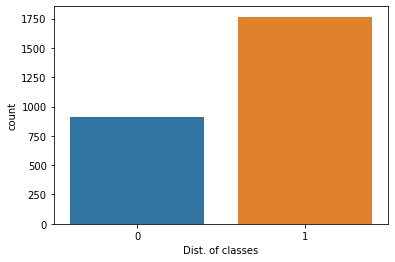

In [ ]:
sns.countplot(train_data.iloc[:,0])
plt.xlabel("Dist. of classes")

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('NbAiLab/nb-bert-base')

In [ ]:
sample = train_data.iloc[1,1]
tokens = tokenizer.tokenize(sample)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: Klipperen har overtatt Seagals martial art , og slåssinga er så kjipt og kjapt klippet at filmen antakelig kunne ha inneholdt Titanics undergang uten at du oppdaget det .
Tokens: ['K', '##lip', '##pere', '##n', 'har', 'over', '##tatt', 'Sea', '##gal', '##s', 'martial', 'art', ',', 'og', 'slå', '##ssing', '##a', 'er', 'så', 'k', '##ji', '##pt', 'og', 'k', '##ja', '##pt', 'klip', '##pet', 'at', 'filmen', 'ant', '##ake', '##lig', 'kunne', 'ha', 'inne', '##holdt', 'Titanic', '##s', 'under', '##gang', 'uten', 'at', 'du', 'oppdaget', 'det', '.']
Token IDs: [148, 69553, 62443, 10115, 10453, 10491, 35962, 14741, 17026, 10107, 65187, 11938, 117, 10156, 86322, 63400, 10113, 10163, 12543, 179, 10775, 14971, 10156, 179, 10320, 14971, 105565, 19094, 10160, 25145, 14917, 26389, 12554, 15376, 10228, 24569, 32421, 47511, 10107, 10571, 13755, 34184, 10160, 10168, 98124, 10349, 119]


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


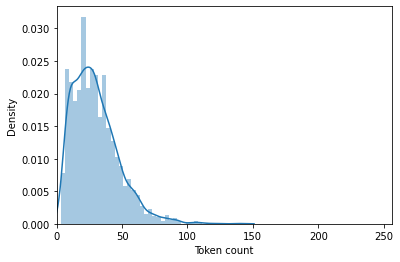

In [ ]:
token_lens = []
for txt in train_data.iloc[:,1]:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
max_seq_length = 150
train_encodings = tokenizer(list(train_data[1]), truncation=True, padding=True, max_length=max_seq_length)
val_encodings = tokenizer(list(dev_data[1]), truncation=True, padding=True, max_length=max_seq_length)
test_encodings = tokenizer(list(test_data[1]), truncation=True, padding=True, max_length=max_seq_length)

In [ ]:
class NorskFilmKritikk(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NorskFilmKritikk(train_encodings, list(train_data[0]))
val_dataset = NorskFilmKritikk(val_encodings, list(dev_data[0]))
test_dataset = NorskFilmKritikk(test_encodings, list(test_data[0]))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
class BertClassifier(nn.Module):
  def __init__(self, freeze_bert=False):
    super(BertClassifier, self).__init__()
    D_in, H, D_out = 768, 50, 2
    
    self.bert = BertModel.from_pretrained('NbAiLab/nb-bert-base')

    self.classifier = nn.Sequential(
        nn.Linear(D_in, H),
        nn.ReLU(),
        nn.Linear(H, D_out)
    )

    if freeze_bert:
      for param in self.bert_parameters():
        param.requires_grad = False
    
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask)
    last_hidden_state_cls = outputs[0][:, 0, :]

    logits=self.classifier(last_hidden_state_cls)

    return logits

In [ ]:
def init_model(epochs=10):
  model = BertClassifier()
  optim = AdamW(model.parameters(),
                lr=5e-5,
                eps=1e-8)
  total_steps = epochs*len(train_loader)
  scheduler = get_linear_schedule_with_warmup(optim,
                                              num_warmup_steps=2*len(train_loader),
                                              num_training_steps=total_steps)
  
  return model, optim, scheduler
  

In [ ]:
def train(model, train_loader, val_loader=None, epochs=10, 
          eval=False, plot_bool=False):
  criterion = nn.CrossEntropyLoss()
  print("Training commenced.")
  model.to(device)
  model.train()
  for epoch in range(epochs):
    tot_loss, batch_loss, batch_count = 0,0,0

    for batch in train_loader:
      optim.zero_grad()

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      logits = model(input_ids, attention_mask)

      loss = criterion(logits, labels)
      tot_loss+=loss.item()
      batch_loss+=loss.item()

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optim.step()
      scheduler.step()

    avg_train_loss = tot_loss / len(train_loader)
    print(f'Epoch: {epoch+1}')
    if eval:
      val_loss, val_acc = evaluate(model, val_loader, criterion)
      print(f'Avg. train loss: {avg_train_loss:.5} | Val. loss: {val_loss:.5} | Val. acc. {val_acc:.3}')
    else:
      print(f'Avg. train loss: {avg_train_loss}')

  if plot_bool:
    plot_loss(avg_train_loss, val_loss)

In [ ]:
def evaluate(model, eval_data, criterion):
  model.eval()
  val_acc = []
  val_loss = []

  for batch in eval_data:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
      logits = model(input_ids, attention_mask)
    
    loss = criterion(logits, labels)
    val_loss.append(loss.item())

    preds = torch.argmax(logits, dim=1).flatten()

    acc = (preds == labels).cpu().numpy().mean() * 100
    val_acc.append(acc)
  
  val_loss = np.mean(val_loss)
  val_acc = np.mean(val_acc)

  return val_loss, val_acc

In [ ]:
def plot_loss(train_loss, val_loss):
  plt.plot(val_loss,       label="Valididation loss")
  plt.plot(avg_train_loss, label='Train loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

 1.06


In [ ]:
bert_classifier, optim, scheduler = init_model(epochs=10)
train(bert_classifier, train_loader, val_loader=val_loader, epochs=10, eval=True)